In [222]:
import post_proc as pp
import csv
import threading
from pathlib import Path
import paper_classes as pc
import multiprocessing as mp
import LP as optim
import pyomo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytest

In [2]:
df=pd.read_csv('Output/df_110144756389_CH_PV50_NMC_0110_7.0_0111_SFH100.csv',engine='python',sep=',',index_col=[0])
df.index=pd.to_datetime(df.index,utc=True)
df.index=df.index.tz_convert('Europe/Brussels')

In [171]:
df.keys()

Index(['Bool_char', 'Bool_cons', 'Bool_dis', 'Bool_hp', 'Bool_hpdhw',
       'Bool_inj', 'E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt',
       'E_PV_grid', 'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu',
       'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu',
       'E_budhw', 'E_char', 'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'SOC', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Export_price', 'price',
       'Inv_P', 'Conv_P', 'Req_kWh', 'Req_kWh_DHW', 'Set_T', 'Temp',
       'Temp_supply', 'Temp_supply_tank', 'T_aux_supply', 'COP_tank', 'COP_SH',
       'COP_DHW', 'Cooling'],
      dtype='object')

In [172]:
def get_revenue(df,conf):
    Rev_batt=0
    Rev_ts_sh=0
    Rev_ts_dhw=0
    if conf>=3:
        Batt_rev_pvsc=(df.E_dis*.95*df.price-df.E_PV_batt*.98*.95*df.Export_price).sum()
        Batt_rev_dls=(df[df.price==df.price.max()].E_dis*.95*df[df.price==df.price.max()].price).sum()-(df[df.price==df.price.min()].E_grid_batt*df[df.price==df.price.min()].price).sum()
        Rev_batt=Batt_rev_pvsc+Batt_rev_dls-(df[df.price==df.price.max()].E_dis*.95*df[df.price==df.price.max()].price).sum()
    if (conf!=0)&(conf!=3):
        # Equivalent electric energy discharged @ peak time that otherwhise would be covered by the HP directly
        Ts_dis=df[(df.price==df.price.max())].Q_ts_sh/df[(df.price==df.price.max())].COP_SH

        Ts_grid_ts=df[(df.price==df.price.min())&(df.Q_hp_ts>0)].E_grid_hp+df[(df.price==df.price.min())&(df.Q_hp_ts>0)].E_grid_bu # Electricity used to charge the tank @ off peak time

        Ts_sh_rev_dls=(Ts_dis*df[(df.price==df.price.max())&(df.Q_ts_sh>0)].price).sum()-(Ts_grid_ts*df[(df.price==df.price.min())&
                       (df.Q_hp_ts>0)].price).sum()

        # Equivalent electric energy discharged that otherwhise would be covered by the HP directly
        Ts_dis=df.Q_ts_sh/df.COP_SH 

        E_PV_hp=df[(df.Q_hp_ts>0)].E_PV_hp+df[(df.Q_hp_ts>0)].E_PV_bu # Electricity used to charge the tank @ when PV

        Ts_sh_rev_pvsc=(Ts_dis*df.price).sum()-(E_PV_hp*df.Export_price).sum()
        Rev_ts_sh=Ts_sh_rev_pvsc+Ts_sh_rev_dls-(Ts_dis*df[(df.price==df.price.max())&(df.Q_ts_sh>0)].price).sum()
    if (conf==2)|(conf==5):
        # Equivalent electric energy discharged @ peak time that otherwhise would be covered by the HP directly
        Dhw_dis=df[(df.price==df.price.max())].Q_dhwst_hd/df[(df.price==df.price.max())].COP_DHW 

        Dhw_grid_ts=df[(df.price==df.price.min())].E_grid_hpdhw+df[(df.price==df.price.min())].E_grid_budhw # Electricity used to charge the tank @ off peak time

        Ts_dhw_rev_dls=(Dhw_dis*df[(df.price==df.price.max())&(df.Q_ts_sh>0)].price).sum()-(Dhw_grid_ts*df[(df.price==df.price.min())&
                       (df.Q_hp_ts>0)].price).sum()
        Rev_ts_sh=Ts_sh_rev_pvsc+Ts_sh_rev_dls-(Ts_dis*df[(df.price==df.price.max())&(df.Q_ts_sh>0)].price).sum()

        # Equivalent electric energy discharged that otherwhise would be covered by the HP directly
        Dhw_dis=df.Q_dhwst_hd/df.COP_DHW

        E_PV_hpdhw=df.E_PV_hpdhw+df[(df.Q_hp_ts>0)].E_PV_budhw # Electricity used to charge the tank @ when PV

        Ts_dhw_rev_pvsc=(Dhw_dis*df.price).sum()-(E_PV_hpdhw*df.Export_price).sum()
        Rev_ts_dhw=Ts_dhw_rev_dls+Ts_dhw_rev_pvsc-(Dhw_dis*df[(df.price==df.price.max())&(df.Q_ts_sh>0)].price).sum()
    return [Rev_batt,Rev_ts_sh,Rev_ts_dhw]

In [521]:
import os
lis=[x for x in os.listdir('./Output') if 'df_' in x ]

In [522]:
lis

['df_110141755829_CH_PV50_NMC_0110_7.0_0100_SFH15.csv',
 'df_110141755828_CH_PV25_NMC_0110_7.0_1100_SFH15.csv',
 'df_110141755831_CH_PV75_NMC_0110_7.0_0100_SFH15.csv',
 'df_110141755828_CH_PV25_NMC_0110_7.0_0100_SFH15.csv',
 'df_110141755830_CH_PV50_NMC_0110_7.0_1100_SFH15.csv',
 'df_110141755827_CH_PV25_NMC_0110_7.0_0100_SFH15.csv']

In [523]:
def test_balances(df,conf,atol):
    
    bal_PV=np.isclose((df.E_PV_batt+df.E_PV_bu+df.E_PV_budhw+df.E_PV_curt+df.E_PV_grid+df.E_PV_hp+df.E_PV_hpdhw+df.E_PV_load+df.E_loss_inv_PV+
             df.E_loss_conv).sum()/df.E_PV.sum(),1,atol=atol)
    if conf>=3:
        bal_batt=np.isclose((df.E_batt_bu+df.E_batt_budhw+df.E_batt_hp+df.E_batt_hpdhw+df.E_batt_load+df.E_loss_inv_batt+
             df.E_loss_Batt).sum()/df.E_char.sum(),1,atol=atol)
        assert bal_batt
    bal_grid=np.isclose((df.E_grid_batt+df.E_grid_bu+df.E_grid_budhw+df.E_grid_hp+df.E_grid_hpdhw+df.E_grid_load+
              df.E_loss_inv_grid).sum()/df.E_cons.sum(),1,atol=atol)
    if (conf==2)|(conf==5):
        bal_dhw=np.isclose((df.Q_dhwst_hd+df.Q_loss_dhwst).sum()/(df.E_hpdhw*df.COP_DHW+df.E_budhw).sum(),1,atol=atol)
        assert bal_dhw
    if (conf!=0)&(conf!=3):
        bal_hp=np.isclose(df.Q_hp_ts.sum()/(df.E_hp*df.COP_tank+df.E_bu).sum(),1,atol=atol)
        bal_ts=np.isclose((df.Q_loss_ts+df.Q_ts_sh+df.Q_ts_delta).sum()/(df.Q_hp_ts+df.E_bu).sum(),1,atol=atol)
        assert bal_hp 
        assert bal_ts 
    else:
        bal_hp=np.isclose(df.Q_hp_sh.sum()/(df.E_hp*df.COP_SH+df.E_bu).sum(),1,atol=atol)
        
        assert bal_hp 
        
    
    assert bal_PV
    assert bal_grid
    

In [524]:
for file in lis:
    df=pd.read_csv('Output/'+file,engine='python',sep=',',index_col=[0])
    df.index=pd.to_datetime(df.index,utc=True)
    df.index=df.index.tz_convert('Europe/Brussels')
    app=file.split('_')[5]
    if app=='0110':
        app=[0,1,1,0]
    elif app=='0111':
        app=[0,1,1,1]
    conf=file.split('_')[7]
    if conf=='0100':
        conf=0
    elif conf=='0110':
        conf=1
    elif conf=='0111':
        conf=2
    elif conf=='1100':
        conf=3
    elif conf=='1110':
        conf=4
    elif conf=='1111':
        conf=5
    #if app[3]==False:
    [batt,ts,dhw]=get_revenue(df,conf)
    bill=get_bills(app,df)
    print(file)
    print('The total bill is {}'.format(bill))
    test_balances(df,conf,1e-2)
    print('The revenues due to the battery are {}'.format(batt))
    print('The revenues due to the SH tank are {}'.format(ts))
    print('The revenues due to the DHW tank are {}'.format(dhw))
    print('############')

Getting bill
df_110141755829_CH_PV50_NMC_0110_7.0_0100_SFH15.csv
The total bill is 122.35143486597954
The revenues due to the battery are 0
The revenues due to the SH tank are 0
The revenues due to the DHW tank are 0
############
Getting bill
df_110141755828_CH_PV25_NMC_0110_7.0_1100_SFH15.csv
The total bill is 45.43914414109573
The revenues due to the battery are 44.321635290830585
The revenues due to the SH tank are 0
The revenues due to the DHW tank are 0
############
Getting bill
df_110141755831_CH_PV75_NMC_0110_7.0_0100_SFH15.csv
The total bill is 43.85028883781024
The revenues due to the battery are 0
The revenues due to the SH tank are 0
The revenues due to the DHW tank are 0
############
Getting bill
df_110141755828_CH_PV25_NMC_0110_7.0_0100_SFH15.csv
The total bill is 140.76657001478097
The revenues due to the battery are 0
The revenues due to the SH tank are 0
The revenues due to the DHW tank are 0
############
Getting bill
df_110141755830_CH_PV50_NMC_0110_7.0_1100_SFH15.csv


In [504]:
file='df_110144756389_CH_PV50_NMC_0110_7.0_1100_SFH45.csv'
df=pd.read_csv('Output/'+file,engine='python',sep=',',index_col=[0])
df.index=pd.to_datetime(df.index,utc=True)
df.index=df.index.tz_convert('Europe/Brussels')
app=file.split('_')[5]
if app=='0110':
    app=[0,1,1,0]
elif app=='0111':
    app=[0,1,1,1]
conf=file.split('_')[7]
if conf=='0100':
    conf=0
elif conf=='0110':
    conf=1
elif conf=='0111':
    conf=2
elif conf=='1100':
    conf=3
elif conf=='1110':
    conf=4
elif conf=='1111':
    conf=5
#if app[3]==False:

In [505]:
[batt,ts,dhw]=get_revenue(df,conf)
bill=get_bills(app,df)
print(file)
print('The total bill is {}'.format(bill))
test_balances(df,conf,1e-4)
print('The revenues due to the battery are {}'.format(batt))
print('The revenues due to the SH tank are {}'.format(ts))
print('The revenues due to the DHW tank are {}'.format(dhw))
print('############')

Getting bill
df_110144756389_CH_PV50_NMC_0110_7.0_1100_SFH45.csv
The total bill is 681.7034032412586
The revenues due to the battery are 327.12834755825463
The revenues due to the SH tank are 0
The revenues due to the DHW tank are 0
############


In [437]:
[batt,ts,dhw]=get_revenue(df,conf)
bill=get_bills(app,df)
print(file)
print('The total bill is {}'.format(bill))
test_balances(df,conf,1e-4)
print('The revenues due to the battery are {}'.format(batt))
print('The revenues due to the SH tank are {}'.format(ts))
print('The revenues due to the DHW tank are {}'.format(dhw))
print('############')

Getting bill
df_110144756389_CH_PV50_NMC_0110_7.0_0100_SFH45.csv
The total bill is 963.2642314405151
The revenues due to the battery are 0
The revenues due to the SH tank are 0
The revenues due to the DHW tank are 0
############


In [459]:
df['cons2']=(df.E_demand+df.Req_kWh/df.COP_SH)

In [473]:
(df.cons2*df.price).sum()

1600.9244170866054

In [512]:
clusters=pd.read_csv('Input/clusters.csv',index_col=[0])

In [514]:
clusters.head()

,name,cluster,country
0,1,2.0,US
1,2,4.0,US
2,3,6.0,US
3,4,2.0,US
4,5,3.0,US


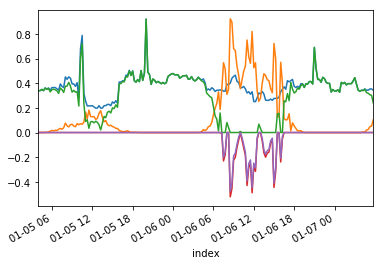

In [489]:
df.cons2[400:600].plot()
df.E_PV[400:600].plot()
(df.cons2-df[['E_PV','cons2']].min(axis=1))[400:600].plot()
(-(df.E_PV-df[['E_PV','cons2']].min(axis=1)))[400:600].plot()
(-df.E_PV_grid)[400:600].plot()

SC

In [484]:
df.E_bu.sum()

0.039028608115289375

In [490]:
df.keys()

Index(['Bool_char', 'Bool_cons', 'Bool_dis', 'Bool_hp', 'Bool_hpdhw',
       'Bool_inj', 'E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt',
       'E_PV_grid', 'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu',
       'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu',
       'E_budhw', 'E_char', 'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'SOC', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Export_price', 'price',
       'Inv_P', 'Conv_P', 'Req_kWh', 'Req_kWh_DHW', 'Set_T', 'Temp',
       'Temp_supply', 'Temp_supply_tank', 'T_aux_supply', 'COP_tank', 'COP_SH',
       'COP_DHW', 'Cooling', 'cons2'],
      dtype='object')

In [493]:
((df.E_loss_inv+df.E_loss_conv)*df.price).sum()

78.23143529694167

In [499]:
SC=pd.DataFrame([df.E_PV*.98*.95,df.cons2]).min(axis=0)

In [503]:
((df.cons2-SC)*df.price-(df.E_PV-SC)*df.Export_price).sum()

945.5640266911338

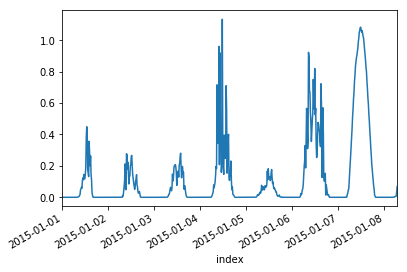

In [468]:
df.E_PV[:700].plot()

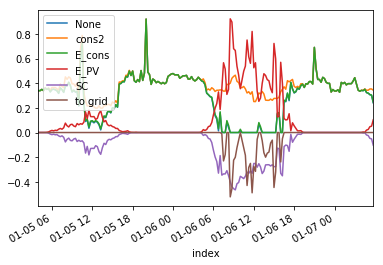

In [481]:
(df.cons2-df[['E_PV','cons2']].min(axis=1))[400:600].plot()
df.cons2[400:600].plot()
df.E_cons[400:600].plot()
df.E_PV[400:600].plot()
(-df[['E_PV','cons2']].min(axis=1)[400:600]).plot(label='SC')
(-(df.E_PV-df[['E_PV','cons2']].min(axis=1))[400:600]).plot(label='to grid')
plt.legend()

In [444]:
(df.E_hp+df.E_bu).sum()

2970.8873501853427

In [438]:
df.E_PV_hp.sum()

585.5832142798391

In [426]:
[batt,ts,dhw]=get_revenue(df,conf)
bill=get_bills(app,df)
print(file)
print('The total bill is {}'.format(bill))
test_balances(df,conf,1e-4)
print('The revenues due to the battery are {}'.format(batt))
print('The revenues due to the SH tank are {}'.format(ts))
print('The revenues due to the DHW tank are {}'.format(dhw))
print('############')

Getting bill
df_110144756389_CH_PV50_NMC_0110_7.0_0110_SFH45.csv
The total bill is 813.7789307044491
The revenues due to the battery are 0
The revenues due to the SH tank are 234.21398856665394
The revenues due to the DHW tank are 0
############


In [427]:
Ts_dis=df[(df.price==df.price.max())].Q_ts_sh/df[(df.price==df.price.max())].COP_SH

Ts_grid_ts=df[(df.price==df.price.min())&(df.Q_hp_ts>0)].E_grid_hp+df[(df.price==df.price.min())&(df.Q_hp_ts>0)].E_grid_bu # Electricity used to charge the tank @ off peak time

Ts_sh_rev_dls=(Ts_dis*df[(df.price==df.price.max())&(df.Q_ts_sh>0)].price).sum()-(Ts_grid_ts*df[(df.price==df.price.min())&
               (df.Q_hp_ts>0)].price).sum()

# Equivalent electric energy discharged that otherwhise would be covered by the HP directly
Ts_dis=df.Q_ts_sh/df.COP_SH 

E_PV_hp=df[(df.Q_hp_ts>0)].E_PV_hp+df[(df.Q_hp_ts>0)].E_PV_bu # Electricity used to charge the tank @ when PV

Ts_sh_rev_pvsc=(Ts_dis*df.price).sum()-(E_PV_hp*df.Export_price).sum()
Rev_ts_sh=Ts_sh_rev_pvsc+Ts_sh_rev_dls-(Ts_dis*df[(df.price==df.price.max())&(df.Q_ts_sh>0)].price).sum()

In [432]:
df.E_PV_hp.sum()

943.8975513108351

In [428]:
Ts_sh_rev_pvsc


583.1188650019105

In [429]:
Ts_sh_rev_dls

36.687830679418994

In [430]:
Rev_ts_sh

234.21398856665394

In [421]:
Batt_rev_pvsc=(df.E_dis*.95*df.price-df.E_PV_batt*.95*df.Export_price).sum()
Batt_rev_dls=(df[df.price==df.price.max()].E_dis*.95*df[df.price==df.price.max()].price).sum()-(df[df.price==df.price.min()].E_grid_batt*df[df.price==df.price.min()].price).sum()
Rev_batt=Batt_rev_pvsc+Batt_rev_dls-(df[df.price==df.price.max()].E_dis*.95*df[df.price==df.price.max()].price).sum()

In [422]:
Batt_rev_pvsc

449.910550405403

In [423]:
Batt_rev_dls

360.67171802899014

In [424]:
Batt_rev_pvsc+Batt_rev_dls-(df[df.price==df.price.max()].E_dis*.95*df[df.price==df.price.max()].price).sum()

325.9364390381055

In [300]:
Rev_batt

303.5979419417205

In [288]:
df.sum().round(2)[35:]

E_loss_inv_PV            334.97
E_loss_inv_batt            0.00
E_loss_inv_grid            0.00
Q_dhwst_hd                 0.00
Q_hp_sh                11745.91
Q_hp_ts                    0.00
Q_loss_dhwst               0.00
Q_loss_ts                  0.00
Q_ts                       0.00
Q_ts_delta                 0.00
Q_ts_sh                    0.00
SOC                        0.00
T_dhwst             10972776.00
T_ts                10574833.36
E_demand                4433.86
E_PV                    6868.98
Export_price            1411.32
price                   7576.22
Inv_P                  24455.21
Conv_P                 23115.33
Req_kWh                11745.91
Req_kWh_DHW             3665.64
Set_T               10190216.00
Temp                 9935872.80
Temp_supply         10364352.34
Temp_supply_tank    10415708.56
T_aux_supply        10415708.56
COP_tank              170060.74
COP_SH                172267.41
COP_DHW               102936.88
Cooling                    0.00
dtype: f

In [173]:
[batt,ts,dhw]=get_revenue(df,2)
print('The revenues due to the battery are {}'.format(batt))
print('The revenues due to the SH tank are {}'.format(ts))
print('The revenues due to the DHW tank are {}'.format(dhw))

The revenues due to the battery are 0
The revenues due to the SH tank are 72.36720359790738
The revenues due to the DHW tank are 0.0


In [174]:
bill=get_bills([0,1,1,0],df)
print('The total bill is {}'.format(bill))


Getting bill
The total bill is 516.9449131353759


In [167]:
bill=get_bills([0,1,1,0],df)
print('The total bill is {}'.format(bill))


Getting bill
The total bill is 561.2956725783357


In [155]:

def get_bills(App_comb,df):
    print('Getting bill')
    Capacity_tariff=9.39
    bill_power=0
    if App_comb[3]:

        P_max_month=df.groupby([df.index.month]).E_cons.max()*4
        bill_power=P_max_month*Capacity_tariff


    bill_energy_min=df.E_cons*df.price-df.E_PV_grid*df.Export_price

    bill_energy_day=bill_energy_min.groupby([df.index.month, df.index.day]).sum()

    bill=bill_energy_day#+bill_power

    bill=(bill.unstack().sum(axis=1)+bill_power).reset_index(drop=True)

    return bill.sum()